In [1]:
import pystac_client
import planetary_computer as pc

#import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os
from shapely.geometry import box


Open SB county coastal zone shapefile (rough polygon)

In [4]:
fp = os.path.join(os.getcwd(),'sb_coast_polygon','coastal_buffer.shp')
geom = gpd.read_file(fp)
geom

,id,geometry
0,0,"POLYGON ((-120.65862 34.98381, -120.61848 34.9..."


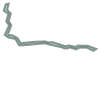

In [5]:
geom.geometry[0]

# Find items of all NAIP scenes that intersect SB county coastal zone (1000 yards from perimeter)

In [2]:
# geometry = geometry that NAIP scenes must intersect
# year = year of the NAIP scenes you want
# returns a list of the items of NAIP scenes from year that intersect geometry
def query_geom(geom, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=geom, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None
    return items


In [29]:
year = 2020
coast_scenes = query_geom(geom.geometry[0],year)
print(len(coast_scenes))
#coast_scenes

27


[<Item id=ca_m_3412037_nw_10_060_20200607>,
 <Item id=ca_m_3412037_ne_10_060_20200607>,
 <Item id=ca_m_3412029_sw_10_060_20200607>,
 <Item id=ca_m_3412028_ne_10_060_20200607>,
 <Item id=ca_m_3412004_sw_10_060_20200607>,
 <Item id=ca_m_3412004_nw_10_060_20200607>,
 <Item id=ca_m_3412003_se_10_060_20200607>,
 <Item id=ca_m_3412003_ne_10_060_20200607>,
 <Item id=ca_m_3412038_nw_10_060_20200523>,
 <Item id=ca_m_3412040_nw_10_060_20200522>,
 <Item id=ca_m_3412040_ne_10_060_20200522>,
 <Item id=ca_m_3412039_nw_10_060_20200522>,
 <Item id=ca_m_3412039_ne_10_060_20200522>,
 <Item id=ca_m_3412038_ne_10_060_20200522>,
 <Item id=ca_m_3411933_nw_11_060_20200522>,
 <Item id=ca_m_3411933_ne_11_060_20200522>,
 <Item id=ca_m_3411945_nw_11_060_20200521>,
 <Item id=ca_m_3411937_sw_11_060_20200521>,
 <Item id=ca_m_3411937_se_11_060_20200521>,
 <Item id=ca_m_3411936_sw_11_060_20200521>,
 <Item id=ca_m_3411936_se_11_060_20200521>,
 <Item id=ca_m_3411935_sw_11_060_20200521>,
 <Item id=ca_m_3411935_se_11_060

In [32]:
# extract itemids and create dataframe
itemids = []
for item in coast_scenes:
    itemids.append(item.id)
    
itemids_df = pd.DataFrame(itemids, columns = ['itemid'])
itemids_df['year'] = year
itemids_df.head(3)

,itemid,year
0,ca_m_3412037_nw_10_060_20200607,2020
1,ca_m_3412037_ne_10_060_20200607,2020
2,ca_m_3412029_sw_10_060_20200607,2020


In [34]:
# save item ids
itemids_df.to_csv(os.path.join(os.getcwd(),'temp','coastal_scenes_ids_'+str(year)+'.csv'), index=False)

# Group NAIP scenes by date

In [8]:
def make_bbox(item):
    c = item.properties['proj:bbox']
    return box(c[0],c[1],c[2],c[3])

In [35]:
# make dataframe with collected scenes and relevant info
df = pd.DataFrame(coast_scenes, columns = ['item'])
df['date']=df.item.apply(lambda item : item.properties['datetime'])
df['crs']=df.item.apply(lambda item : item.properties['proj:epsg'])
df['bbox']=df.item.apply(make_bbox)
df.shape

(27, 4)

In [37]:
def group_flight(df,date):
    same_date = df[df['date']==date]
    
    crs_list = same_date.crs.unique()
    polygons = []
    for crs in crs_list:
        same_crs = same_date[same_date['crs']==crs]
        area = shapely.ops.unary_union(same_crs.bbox)
        gdf = gpd.GeoDataFrame({'geometry':[area]}, 
                               crs='EPSG:'+str(crs))
        gdf.to_crs('EPSG:4326',inplace=True)
        polygons.append(gdf.geometry[0])

        flight = shapely.ops.unary_union(polygons)

    return flight

# --------------------------------------------------------------------------------------------------------

def flight_paths(df):
    dates = df.date.unique()
    flights = []
    for date in dates:
        flights.append(group_flight(df,date))
    gdf = gpd.GeoDataFrame({'date':dates, 'geometry':flights},
                     crs = 'EPSG:4326')
    return gdf

In [38]:
flights = flight_paths(df)

In [39]:
flights

,date,geometry
0,2020-06-07T00:00:00Z,"MULTIPOLYGON (((-120.50411 34.49829, -120.5022..."
1,2020-05-23T00:00:00Z,"POLYGON ((-120.31043 34.43430, -120.30827 34.5..."
2,2020-05-22T00:00:00Z,"POLYGON ((-119.87062 34.43581, -119.93956 34.4..."
3,2020-05-21T00:00:00Z,"POLYGON ((-119.68958 34.37178, -119.68962 34.3..."


In [15]:
# save if needed
flights.to_file(os.path.join(os.getcwd(),'temp','flights_coast_'+str(year)+'.shp'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
